This notebook:

1. loads in disp rate plots. Choose one to work on.
2. Does a moving window over the disp rate map.
3. For each window, calculates the median criteria value, cuts out all pixels below it.
4. calculates the range of velocities within that range (upper/better half). Max-min velocity within those pixels.
5. saves it to an array to plot. To see where have the biggest differences even within the "good half" of the pixels for each criteria.

This notebook was written 7-13-23. 

***

In [2]:
# import stuff
import os,sys
import glob
import pandas as pd
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget 

In [3]:
# choose 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# larger cropped area with western mountains, shape of rate maps 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

In [4]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(end_indices)
# the last one I just added (4-12-23) as a totally dry period

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
print(str(num_intervals)+' intervals.')

interval 0: 20170510-20181125
interval 1: 20181207-20200412
interval 2: 20200418-20201208
interval 3: 20201214-20220108
interval 4: 20170510-20191220
interval 5: 20170510-20220108
interval 6: 20200412-20210119
7 intervals.


In [5]:
disp_rates = np.ndarray((num_intervals,dy,dx),dtype='float')
disp_rates_errors = np.ndarray((num_intervals,dy,dx),dtype='float')
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
for j in range(num_intervals):    
    # read in disp rate file + rmse file
    fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
    errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
    f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
    disp_rates[j] = f1.ReadAsArray()
    f1 = None
    f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
    disp_rates_errors[j] = f1.ReadAsArray()
    f1 = None
    print('interval '+str(j)+' disp rate map + errors loaded.')

interval 0 disp rate map + errors loaded.
interval 1 disp rate map + errors loaded.
interval 2 disp rate map + errors loaded.
interval 3 disp rate map + errors loaded.
interval 4 disp rate map + errors loaded.
interval 5 disp rate map + errors loaded.
interval 6 disp rate map + errors loaded.


Just making sure they loaded. 

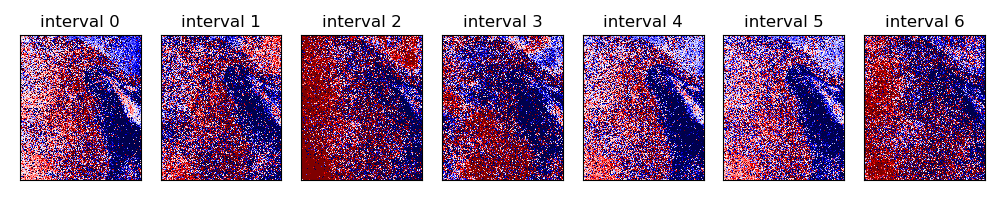

In [6]:
# plot them.
plt.figure(figsize=(10,2),tight_layout=True); count=1
for i in range(num_intervals):
    plt.subplot(1,7,count)
    plt.imshow(disp_rates[i], aspect='auto', vmin=-3.0,vmax=3.0,\
                interpolation='nearest')
    #plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
    plt.set_cmap('seismic')
    plt.xlim([dx,0]); plt.ylim([dy,0])
    plt.xticks([]); plt.yticks([])
    plt.title('interval '+str(i))
    count = count+1
plt.show()

Now load Amp dispersion, Wrap errors, and High pass phase files.

In [7]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

file_name = 'unfilt_unwrapped/wrap_err.i1' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
wrap_err = f1.ReadAsArray(); f1 = None
print('wrap errors for each pixel loaded.')

file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
# cropped area
x1 = 18000; x2 = 14000
y1 = 2100; y2 = 1000
hp_phs = hp[y2:y1,x2:x1]
print('high pass phase for each pixel loaded.')

Amplitude dispersion for each pixel loaded.
wrap errors for each pixel loaded.
high pass phase for each pixel loaded.


Plot them, make sure they loaded properly.

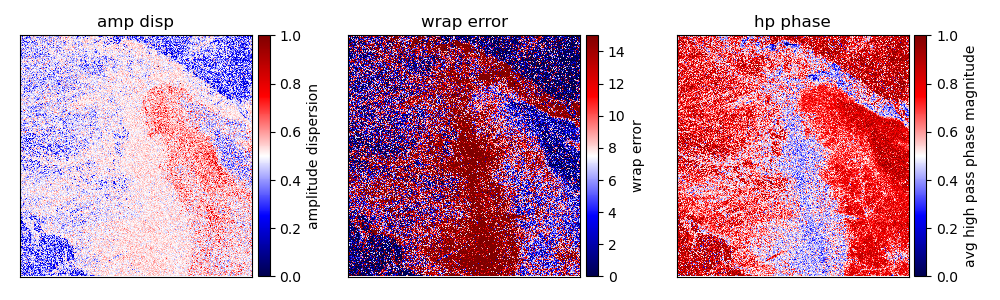

In [8]:
plt.figure(figsize=(10,3),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(amp_dispersion, aspect='auto',interpolation='nearest',vmin=0,vmax=1.0)
plt.colorbar(orientation='vertical',pad=0.02,label='amplitude dispersion')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('amp disp')
plt.subplot(1,3,2)
plt.imshow(wrap_err, aspect='auto',interpolation='nearest',vmin=0,vmax=15)
plt.colorbar(orientation='vertical',pad=0.02,label='wrap error')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('wrap error')
plt.subplot(1,3,3)
plt.imshow(hp_phs, aspect='auto',interpolation='nearest',vmin=0,vmax=1.0)
plt.colorbar(orientation='vertical',pad=0.02,label='avg high pass phase magnitude')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('hp phase')
plt.show()

Make a colormap where Nans are different color: try green.

In [9]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


In [10]:
# which time interval? 
j = 5

Make masks of 0's and 1's for population 1 and population 2 pixels.

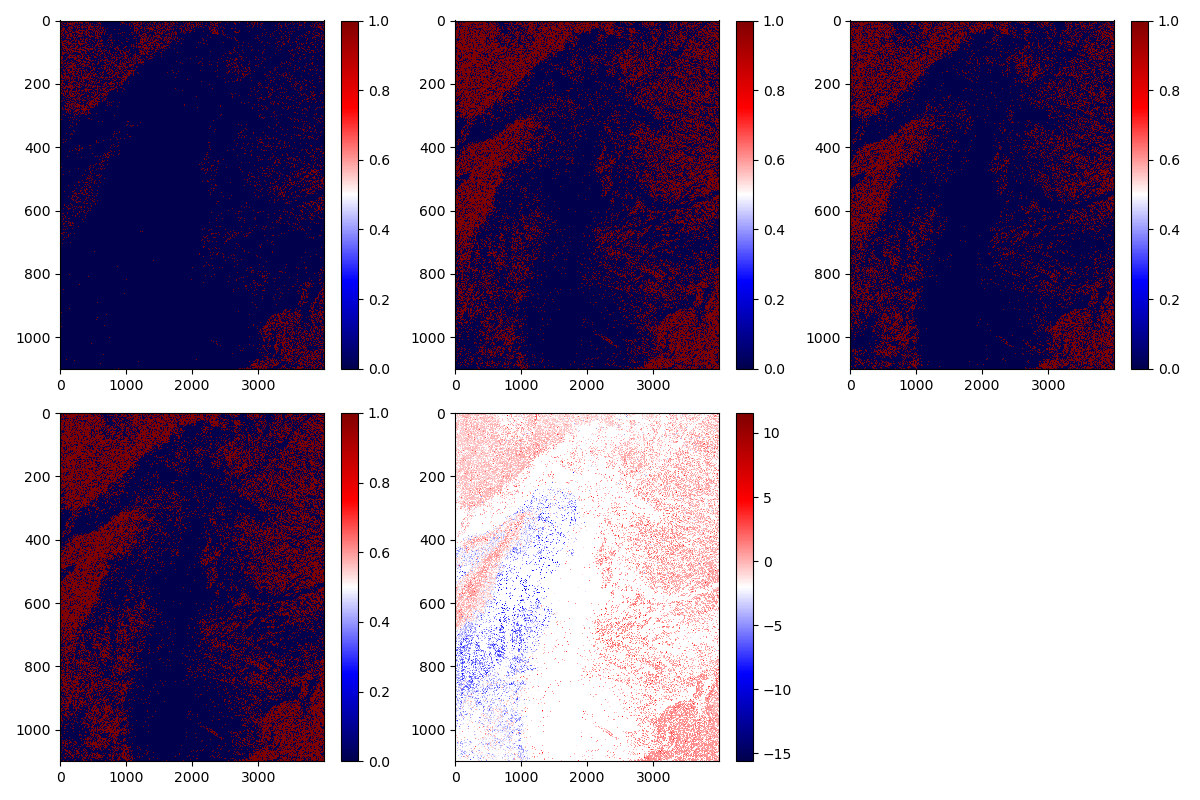

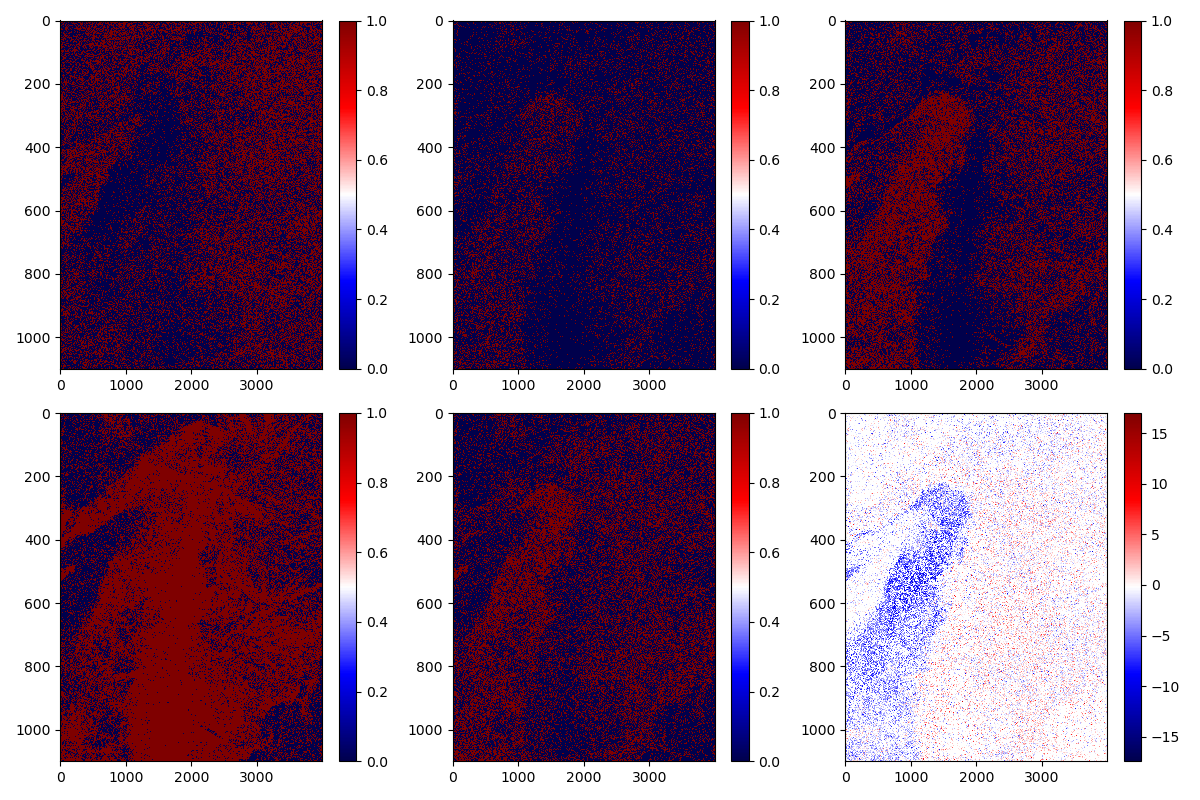

In [12]:
# define thresholds 
ad_best  = 0.35
ad_ok    = 0.5
we_best  = 5
we_ok    = 10
hp_best  = 0.8
hp_ok    = 0.6

# POPULATION 1
# boolean arrays 
ad_pop1_mask = (amp_dispersion<ad_best) 
we_pop1_mask = (wrap_err<we_best) 
hp_pop1_mask = (hp_phs>hp_best)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
pop1_combo_mask = ad_pop1_mask + we_pop1_mask + hp_pop1_mask
# now mask disp rates based on where mask is True/False
pop1_combo = np.ma.masked_where(pop1_combo_mask==False,disp_rates[j])

# POPULATION 2
ad1_pop2_mask = (amp_dispersion>ad_best) 
ad2_pop2_mask = (amp_dispersion<ad_ok) 
we1_pop2_mask = (wrap_err>we_best) 
we2_pop2_mask = (wrap_err<we_ok) 
hp1_pop2_mask = (hp_phs<hp_best)
hp2_pop2_mask = (hp_phs>hp_ok)
pop2_last_mask = (pop1_combo_mask==False)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
pop2_combo_mask = (ad1_pop2_mask*ad2_pop2_mask) + (we1_pop2_mask*we2_pop2_mask) + (hp1_pop2_mask*hp2_pop2_mask)
pop2_combo_mask = pop2_combo_mask * pop2_last_mask 
# now mask disp rates based where mask is False
pop2_combo = np.ma.masked_where(pop2_combo_mask==False,disp_rates[j])

# plot POP 1
plt.figure(figsize=(12,8),tight_layout=True)
plt.subplot(2,3,1)
plt.imshow(ad_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(we_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(hp_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(pop1_combo_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(pop1_combo,aspect='auto',interpolation='none'); plt.colorbar()
plt.show()

# plot POP 2
plt.figure(figsize=(12,8),tight_layout=True)
plt.subplot(2,3,1)
plt.imshow(ad1_pop2_mask*ad2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(we1_pop2_mask*we2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(hp1_pop2_mask*hp2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(pop2_last_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(pop2_combo_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(pop2_combo,aspect='auto',interpolation='none'); plt.colorbar()
plt.show()

THIS IS FOR EACH CRITERIA SEPARATELY <br> <br>
Do a moving window over the map. Calculate median, mask values worse than the median. Calculate max velocity and min velocity in that range. Save to an array. <br><br> Takes ~2.5 hours to run. 

In [13]:
# initialize array of Nans for each criteria.
diffs_ad = np.zeros((dy,dx))*np.nan
diffs_we = np.zeros((dy,dx))*np.nan
diffs_hp = np.zeros((dy,dx))*np.nan
# what's the size of our moving window? 
alooks = 40      # y direction
ylooks = int(alooks/2)
rlooks = 200     # x direction
xlooks = int(rlooks/2)
# set upper and lower percentiles 
upper_percentile = 90   # 95 before, try 75 next for interquartile range
lower_percentile = 10   # 5  before, try 25 next

# loop through pixels 
for y in range(dy):     #dy
    for x in range(dx): #dx
        # only if not an edge pixel
        if y-ylooks >= 0 and y+ylooks < dy and x-xlooks >= 0 and x+xlooks < dx:
            # for this window, pull out the disp rate values, the amp disps, wrap errs, and hp phs values 
            temp_disps = disp_rates[j,y-ylooks:y+ylooks,x-xlooks:x+xlooks]
            temp_ad = amp_dispersion[y-ylooks:y+ylooks,x-xlooks:x+xlooks]
            temp_we = wrap_err[y-ylooks:y+ylooks,x-xlooks:x+xlooks]
            temp_hp = hp_phs[y-ylooks:y+ylooks,x-xlooks:x+xlooks]
            # now calculate the medians
            ad_median = np.median(temp_ad)
            we_median = np.median(temp_we)
            hp_median = np.median(temp_hp)
            # now mask the area based on that median. 
            ad_masked = np.ma.masked_where(temp_ad>ad_median,temp_disps)#.flatten()
            we_masked = np.ma.masked_where(temp_we>we_median,temp_disps)#.flatten()
            hp_masked = np.ma.masked_where(temp_hp<hp_median,temp_disps)#.flatten()
            
            # replace -- in masked arrays with Nans, so that nanpercentile can work. 
            ad_mask_y,ad_mask_x = np.nonzero(ad_masked)
            ad_masked_2 = np.zeros((alooks,rlooks))*np.nan
            ad_masked_2[ad_mask_y,ad_mask_x] = ad_masked[ad_mask_y,ad_mask_x]
            we_mask_y,we_mask_x = np.nonzero(we_masked)
            we_masked_2 = np.zeros((alooks,rlooks))*np.nan
            we_masked_2[we_mask_y,we_mask_x] = we_masked[we_mask_y,we_mask_x]
            hp_mask_y,hp_mask_x = np.nonzero(hp_masked)
            hp_masked_2 = np.zeros((alooks,rlooks))*np.nan
            hp_masked_2[hp_mask_y,hp_mask_x] = hp_masked[hp_mask_y,hp_mask_x]

            # plot the window of data, masked 
            # plt.figure(figsize=(10,6),tight_layout=True)
            # plt.subplot(2,3,1)
            # plt.imshow(ad_masked_2,aspect='auto',cmap=seismic2); plt.title('amp disp'); plt.colorbar()
            # #plt.plot(ad_mask_y,ad_mask_x,'.k',ms=0.5)
            # plt.subplot(2,3,2)
            # plt.imshow(we_masked_2,aspect='auto',cmap=seismic2); plt.title('wrap err'); plt.colorbar()
            # plt.subplot(2,3,3)
            # plt.imshow(hp_masked_2,aspect='auto',cmap=seismic2); plt.title('hp phase'); plt.colorbar()
            # plt.subplot(2,3,4)
            # plt.hist(ad_masked_2.flatten(),bins=100)
            # plt.subplot(2,3,5)
            # plt.hist(we_masked_2.flatten(),bins=100)
            # plt.subplot(2,3,6)
            # plt.hist(hp_masked_2.flatten(),bins=100)
            # plt.show()

            # now calculate the max and min velocity that is leftover after masking for each window
            # diffs_ad[y,x] = np.max(ad_masked) - np.min(ad_masked)
            # diffs_we[y,x] = np.max(we_masked) - np.min(we_masked)
            # diffs_hp[y,x] = np.max(hp_masked) - np.min(hp_masked)
            
            # instead, use upper and lower percentiles. 
            diffs_ad[y,x] = np.nanpercentile(ad_masked_2,upper_percentile) - np.nanpercentile(ad_masked_2,lower_percentile)
            diffs_we[y,x] = np.nanpercentile(we_masked_2,upper_percentile) - np.nanpercentile(we_masked_2,lower_percentile)
            diffs_hp[y,x] = np.nanpercentile(hp_masked_2,upper_percentile) - np.nanpercentile(hp_masked_2,lower_percentile)

            # print('ad')
            # print(np.nanpercentile(ad_masked_2.flatten(),90))
            # print(np.nanpercentile(ad_masked_2.flatten(),10))
            # print(np.nanpercentile(ad_masked_2.flatten(),50))
            # print('we')
            # print(np.nanpercentile(we_masked_2.flatten(),90))
            # print(np.nanpercentile(we_masked_2.flatten(),10))
            # print(np.nanpercentile(we_masked_2.flatten(),50))
            # print('hp')
            # print(np.nanpercentile(hp_masked_2.flatten(),90))
            # print(np.nanpercentile(hp_masked_2.flatten(),10))
            # print(np.nanpercentile(hp_masked_2.flatten(),50))
        else:
            pass
    print('done with row '+str(y))
print('diffs calculated for all 3 criteria for all non-edge pixels.')

plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(diffs_ad, aspect='auto',interpolation='nearest',vmin=0,vmax=10) #,vmin=0,vmax=1.0
plt.colorbar(orientation='vertical',pad=0.02,label='velocity diff (cm/yr)')
plt.title('Amplitude Dispersion')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(diffs_we, aspect='auto',interpolation='nearest',vmin=0,vmax=10)
plt.colorbar(orientation='vertical',pad=0.02,label='velocity diff (cm/yr)')
plt.title('Wrap Errors')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(diffs_hp, aspect='auto',interpolation='nearest',vmin=0,vmax=10)
plt.colorbar(orientation='vertical',pad=0.02,label='velocity diff (cm/yr)')
plt.title('HP Phase')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.show()
plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/Diffs_90-10.png')